### Reference
https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/random_walk.py 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm 
matplotlib.style.use("ggplot")

In [2]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label1.set_fontsize(x_fontsize)
        tick.label1.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label1.set_fontsize(y_fontsize)
        tick.label1.set_rotation(y_rotation)

In [3]:
# 0: left terminal state
# 6: right tterminal state
# 1, 2, 3, 4, 5 correspond to A, B, C, D, E

START_STATE = 3

VALUES = np.zeros(7)
VALUES[1:6] = 0.5
VALUES[6] = 1

TRUE_VALUES = np.zeros(7)
TRUE_VALUES[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUES[6] = 1.
TRUE_VALUES 

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

### Estimate state values 

In [4]:
def temporal_difference(values, alpha=0.1, batch=False):
    state = START_STATE
    trajectory = [state]
    rewards = [0]
    while True:
        old_state = state 
        if np.random.random() < 0.5:
            state -= 1
        else:
            state += 1
        reward = 0
        trajectory.append(state)
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state in [0, 6]:
            break
        rewards.append(reward)
    return trajectory, rewards 
        

In [5]:
def monte_carlo(values, alpha=0.1, batch=False):
    state = START_STATE
    trajectory = [state]
    while True:
        if np.random.random() < 0.5:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state in [0, 6]:
            returns = float(state == 6)
            break 
            
    if not batch:
        for s in trajectory[:-1]:
            values[s] += alpha * (returns - values[s])
    return trajectory, [returns] * (len(trajectory) - 1)


In [6]:
def compute_state_values(method, episodes=[1, 10, 100]):
    assert method in ("TD", "MC")
    state_values = np.copy(VALUES)
    fig, ax = plt.subplots(1, figsize=(7, 6))
    fontsize = 15
    for i in range(episodes[-1] + 1):
        if i in episodes:
            ax.plot(("A", "B", "C", "D", "E"), state_values[1:6], marker=".", markersize=15, label=f"{i} episodes")
        if method == "TD":
            temporal_difference(state_values)
        elif method == "MC":
            monte_carlo(state_values)
        
    ax.plot(("A", "B", "C", "D", "E"), TRUE_VALUES[1:6], lw=1.5, linestyle="--", marker=".", markersize=15, label="True values")
    ax.set_xlabel("State", fontsize=fontsize, labelpad=15)
    ax.set_ylabel("Estimated value", fontsize=fontsize, labelpad=15)
    adjustAxeProperties(ax, fontsize, 0, fontsize, 0)
    ax.legend(loc="best", fontsize=fontsize)
    if method == "TD":
        title_text = "Temporal difference"        
    elif method == "MC":
        title_text = "Monte Carlo"
    ax.set_title(title_text, fontsize=fontsize)

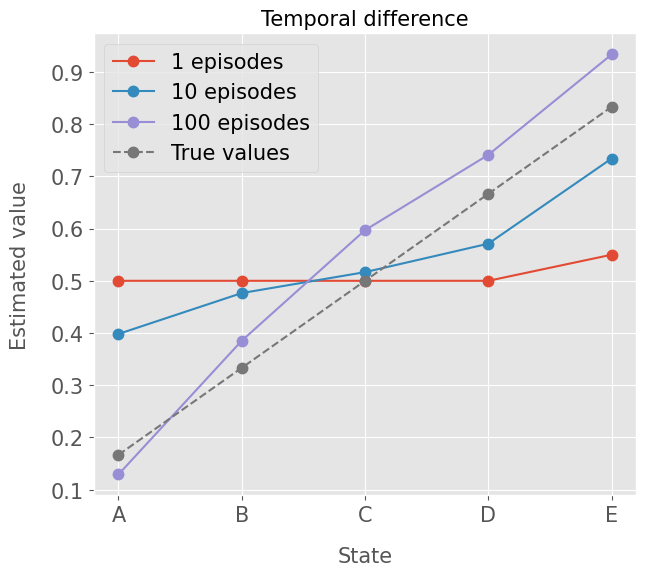

In [7]:
compute_state_values("TD")

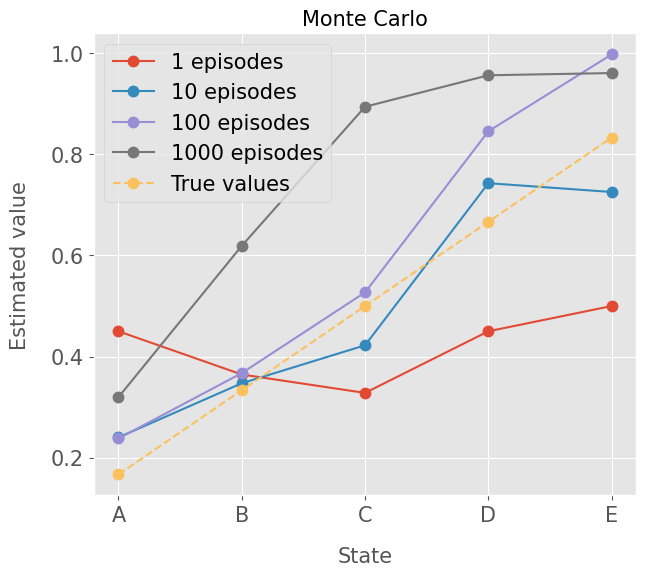

In [8]:
compute_state_values("MC", episodes=[1, 10, 100, 1000])

### Plot learning curves  

In [11]:
def plot_learning_curves():
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    num_episodes = 100 + 1
    num_runs = 100
    fig, ax = plt.subplots(1, figsize=(7, 6))
    fontsize = 15
    for i, alpha in enumerate(td_alphas + mc_alphas):
        if i < len(td_alphas):
            method = "TD"
            linestyle = "solid"
        else:
            method = "MC"
            linestyle = "dashdot"
            
        total_errors = np.zeros(num_episodes)
        
        for run_idx in tqdm(range(num_runs)):
            errors = np.zeros(num_episodes)
            state_values = np.copy(VALUES)
            for i in range(num_episodes):
                rms = np.sqrt(np.sum(np.power(TRUE_VALUES - state_values, 2)) / 5.)
                errors[i] = rms
                if method == "TD":
                    temporal_difference(state_values, alpha=alpha)
                else:
                    monte_carlo(state_values, alpha=alpha)
            total_errors += errors
        total_errors /= num_runs
        ax.plot(total_errors, linestyle=linestyle, label=f"{method}, $\\alpha$={alpha}")
        
    ax.set_xlabel("Episode", fontsize=fontsize, labelpad=15)
    ax.set_ylabel("Empirical RMS error, averaged over states", fontsize=fontsize, labelpad=15)
    adjustAxeProperties(ax, fontsize, 0, fontsize, 0)    
    ax.legend(loc="best", fontsize=fontsize, bbox_to_anchor=(1.05, 1.0))


100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1480.73it/s]


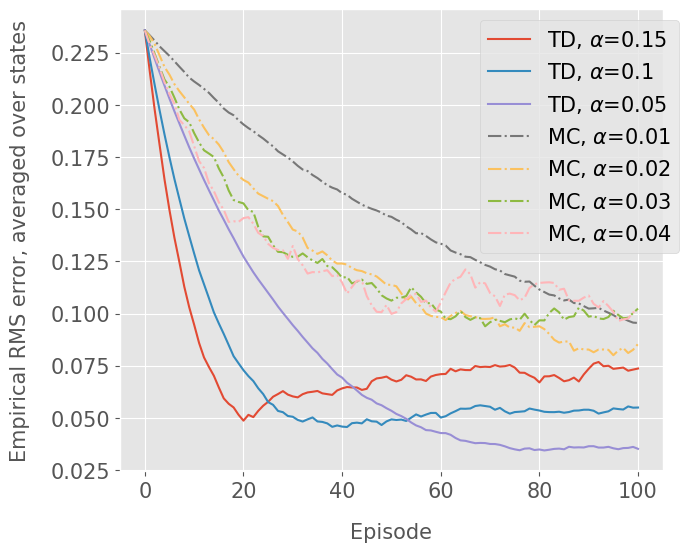

In [12]:
plot_learning_curves()

### Plot batch update's learning curves

In [68]:
def plot_batch_update_learning_curves(method, num_episodes, alpha=0.001):
    assert method in ("TD", "MC")
    num_runs = 100
    total_errors = np.zeros(num_episodes)
    for run_idx in tqdm(range(num_runs)):
        state_values = np.copy(VALUES)
        errors = np.zeros(num_episodes)
        trajectories, rewards = [], []
        for episode_idx in range(num_episodes):
            if method == "TD":
                trajectory_episode, rewards_episode = temporal_difference(state_values, batch=True)
            else:
                trajectory_episode, rewards_episode = monte_carlo(state_values)
            trajectories.append(trajectory_episode)
            rewards.append(rewards_episode)
            while True:
                updates = np.zeros(7)
                for trajectory_episode, rewards_episode in zip(trajectories, rewards):
                    for t in range(len(trajectory_episode) - 1):
                        if method == "TD":
                            s = trajectory_episode[t]
                            s1 = trajectory_episode[t + 1]
                            updates[s] += rewards_episode[t] + state_values[s1] - state_values[s]
                        else:
                            s = trajectory_episode[t]
                            updates[s] += rewards_episode[t] - state_values[s]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break 
                # batch update
                state_values += updates 
            # end of while 
            rms = np.sqrt(np.sum(np.power(TRUE_VALUES - state_values, 2)) / 5.)
            errors[episode_idx] = rms
        total_errors += errors
    total_errors /= num_runs 
    return total_errors 
        

In [69]:
num_episodes = 100 + 1
alpha = 0.001
td_errors = plot_batch_update_learning_curves("TD", num_episodes)
mc_errors = plot_batch_update_learning_curves("MC", num_episodes)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]


Text(0.5, 1.0, 'Batch training')

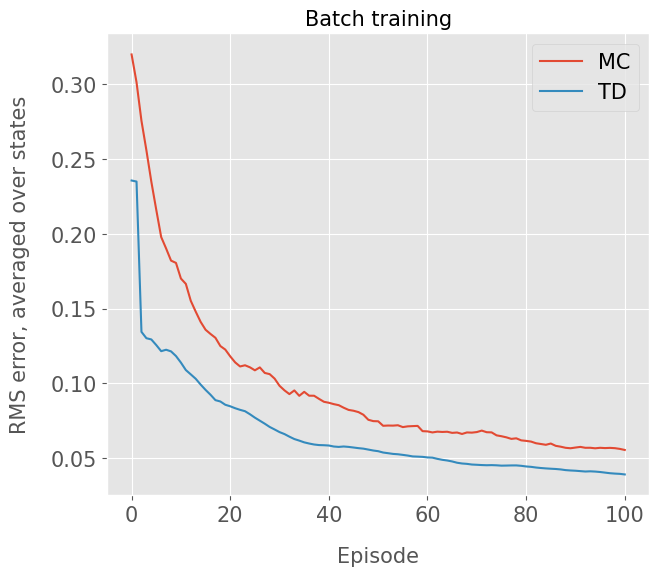

In [72]:
fig, ax = plt.subplots(1, figsize=(7, 6))
fontsize = 15
ax.plot(mc_errors, label="MC")
ax.plot(td_errors, label="TD")
ax.set_xlabel("Episode", fontsize=fontsize, labelpad=15)
ax.set_ylabel("RMS error, averaged over states", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)
ax.legend(loc="best", fontsize=fontsize)
ax.set_title("Batch training", fontsize=fontsize)